# <font color='lightblue'>Airbnb Price Prediction Analysis</font>

## <font color='yellow'>Question</font>

How well can the price (log price) of Airbnb rentals be predicted using machine learning models?

## <font color='lightgreen'>Process</font>

* Identify columns with missing or NaN values
* Plan how to deal with each individual column
* Clean data
* Transform categorical variables into encoded features
* Train a base XGBoost model on the cleaned data
* Evaluate results
* Tune hyperparameters
* Evaluate model
* Plot feature importances

## <font color='pink'>Problem areas</font>:

There are a few problem area areas with this analysis.

The first one is that certain categorical features (neighbourhood), if entirely used and encoded, would lead to extreme levels of dimensionality. These features were not included as a result, with the idea that latitude and longitude may make up for them

The other main problem was processing power available. The machine used for this analysis would have taken days to do a comprehensive grid search of hyperparameters, so performing it in chunks was used instead. Unfortunately, this means that the hyperparameters are not perfectly tuned.

## MAE - 0.272035938048597
## MAPE - 0.05719580023745668

In [40]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as px
import xgboost
import warnings
from xgboost import plot_tree

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 40)

In [41]:
#read in data

data = pd.read_csv('../data/train.csv')

data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [42]:
data.info()

#has missing values:
#bathrooms, first_review, host_has_profile_pic, host_identity_verified, host_response_rate, host_since, last_review, 
#neighbourhood, review_scores_rating, thumbnail_url, zipcode, bedrooms, beds

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

#cleaning/transform:

#date to day, month, year cols: first_review, host_since, last_review
#remove: zipcode, description, name, id
#onehot encode (remove first): property_type, room_type, amenities, bed_type, cancellation_policy, city, neighbourhood
#bool to 1,0: cleaning_fee, thumbnail_url, instant_bookable

#has missing values:

#float (impute): bathrooms, review_scores_rating, bedrooms, beds
#date (-1): first_review, host_since, last_review
#str (fill "unknown"): neighbourhood
#str to bool (nan to 0): host_has_profile_pic, host_identity_verified
#str to int (remove percentages, impute): host_response_rate
#to bool (has value or not): thumbnail_url

data['first_review_day'], data['first_review_year'], data['first_review_month'] = pd.to_datetime(data['first_review']).dt.day, pd.to_datetime(data['first_review']).dt.year, pd.to_datetime(data['first_review']).dt.month
data['host_since_day'], data['host_since_year'], data['host_since_month'] = pd.to_datetime(data['host_since']).dt.day, pd.to_datetime(data['host_since']).dt.year, pd.to_datetime(data['host_since']).dt.month
data['last_review_day'], data['last_review_year'], data['last_review_month'] = pd.to_datetime(data['last_review']).dt.day, pd.to_datetime(data['last_review']).dt.year, pd.to_datetime(data['last_review']).dt.month
data = data.drop(['first_review', 'host_since', 'last_review', 'zipcode', 'description', 'name', 'id'], axis=1)

categorical_variables = ['property_type', 'room_type','bed_type', 'cancellation_policy', 'city']
amenities = data['amenities']
data['neighbourhood'] = data['neighbourhood'].replace(np.nan, 'Unknown')
data = data.drop(['amenities', 'neighbourhood'], axis=1) #neighborhood raises mae
data['cleaning_fee'] = data['cleaning_fee'].map({True: 1, False: 0})
data['host_has_profile_pic'] = data['host_has_profile_pic'].map({'t': 1, 'f': 0, np.nan: 0})
data['host_identity_verified'] = data['host_identity_verified'].map({'t': 1, 'f': 0, np.nan: 0})
data['instant_bookable'] = data['instant_bookable'].map({'t': 1, 'f': 0, np.nan: 0})
data['host_response_rate'] = data['host_response_rate'].astype(str).apply(lambda x: x.replace('%', ''))
data['thumbnail_url'] = data['thumbnail_url'].map(lambda x: 0 if pd.isna(x) else 1)
data['host_response_rate'] = data['host_response_rate'].astype('Float64')

date_cols = ['first_review_day', 'first_review_year', 'first_review_month', 'host_since_day', 'host_since_year', 'host_since_month', 'last_review_day', 'last_review_year', 'last_review_month']
data[date_cols] = data[date_cols].apply(lambda x: x.fillna(-1))

imputed_cols = ['bedrooms', 'bathrooms', 'beds', 'review_scores_rating', 'host_response_rate']
imputer = SimpleImputer(strategy='mean')
imputer.fit(data[imputed_cols])
data[imputed_cols] = imputer.transform(data[imputed_cols])

Text(0.5, 1.0, 'Counts of Property Types')

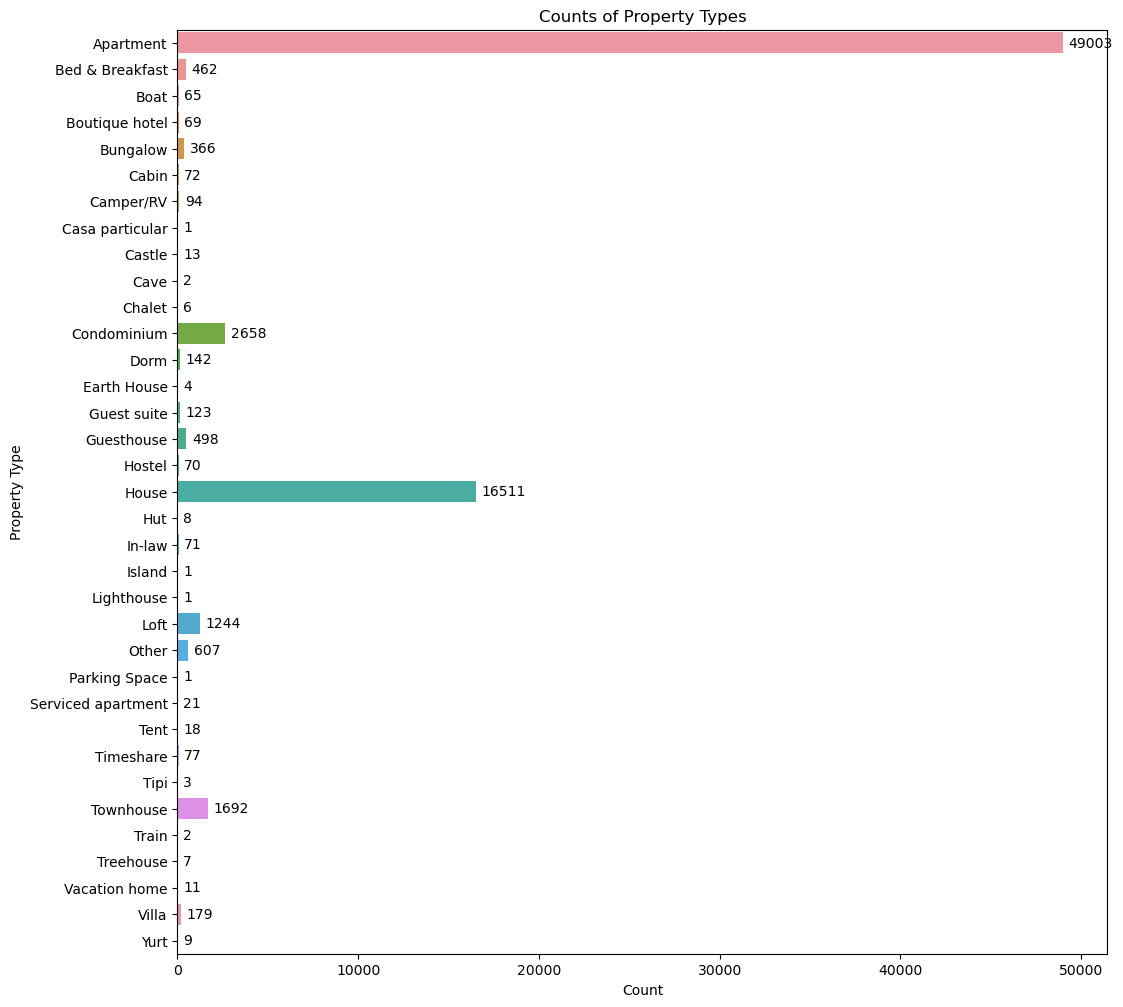

In [44]:
#plot out different property types

fig, ax = plt.subplots(figsize=(12,12))
fig = sns.barplot(x='log_price', data=data.groupby('property_type', as_index=False).count()[['property_type', 'log_price']], y='property_type',)
fig.bar_label(fig.containers[0], padding=4)
fig.set_xlabel('Count')
fig.set_ylabel('Property Type')
fig.set_title('Counts of Property Types')

Text(0.5, 1.0, 'Counts of Cities')

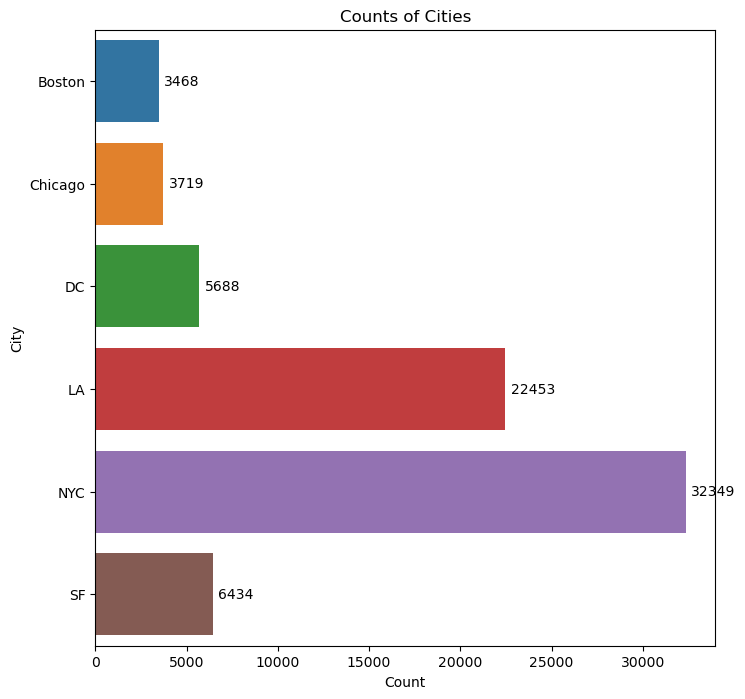

In [45]:
#plot out city counts
fig, ax = plt.subplots(figsize=(8,8))
fig = sns.barplot(x='log_price', data=data.groupby('city', as_index=False).count()[['city', 'log_price']], y='city')
fig.bar_label(fig.containers[0], padding=4)
fig.set_xlabel('Count')
fig.set_ylabel('City')
fig.set_title('Counts of Cities')

In [46]:
#encode categorical variables, train/test split

data = pd.get_dummies(data, columns=categorical_variables, drop_first=True)
X = data.drop('log_price', axis=1)
y = data['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)

In [47]:
#find shape after categorical variables are encoded

data.shape

(74111, 73)

In [48]:
#initialize xgboost and fit to training data

from xgboost import XGBRegressor

boost = XGBRegressor()
boost.fit(X_train, y_train)
boost

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [49]:
#model predictions

y_pred = boost.predict(X_test)

In [50]:
#model MAPE and MAE

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

print(f'MAPE: {mean_absolute_percentage_error(y_pred, y_test)}, MAE: {mean_absolute_error(y_pred, y_test)}')

MAPE: 0.05878560869465756, MAE: 0.2794164988969564


In [23]:
#hyperparameter tuning
#this is done in chunks as to not run the entire grid at once, which would take over 24 hours
#best values are noted by the comments
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3, 4, 5, 6, 7, 8], #8
    'min_child_weight': [1, 3, 5, 7], #5
    'gamma': [0, 0.1, 0.2, 0.3, 0.4], #0.1
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], #0.6
    'n_estimators': [100, 200, 300, 400, 500], #300
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], #0.05
    'reg_alpha': [0, 0.1, 0.5, 1, 2], #0.1
    'reg_lambda': [0, 0.1, 0.5, 1, 2], #0
    'objective': ['reg:squarederror'],
    'eval_metric': ['mae'],
    'booster': ['gbtree'],
    'random_state': [8]
}

grid_search = GridSearchCV(estimator=XGBRegressor(learning_rate=0.05,
                                                  max_depth=8,
                                                  min_child_weight=5,
                                                  n_estimators=300,
                                                  gamma=0.1, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.6, 
                                                  seed=8,
                                                  ),
                           param_grid=params, n_jobs=4, scoring='neg_mean_absolute_error', cv=5)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_, grid_search.best_score_)

{'booster': 'gbtree', 'eval_metric': 'rmse', 'learning_rate': 0.05, 'objective': 'reg:squarederror', 'random_state': 8, 'reg_alpha': 0.1, 'reg_lambda': 0} -0.27456371430471654


In [39]:
#tuned model MAPE and MAE

print(f'MAPE: {mean_absolute_percentage_error(y_pred, y_test)}, MAE: {mean_absolute_error(y_pred, y_test)}')

MAPE: 0.05719580023745668, MAE: 0.272035938048597


In [35]:
#save graph as image (extremely large image)

img = xgboost.to_graphviz(boost)
img.render('graph', format='png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.660732 to fit

(process:5328): GLib-GIO-WARNING **: 17:42:19.913: Unexpectedly, UWP app `18184wherewhere.AndroidAppInstaller_0.1.25.0_x64__4v4sx105x6y4r' (AUMId `18184wherewhere.AndroidAppInstaller_4v4sx105x6y4r!App') supports 4 extensions but has no verbs


'graph.png'

Text(0.5, 1.0, 'Feature Importances (1-32)')

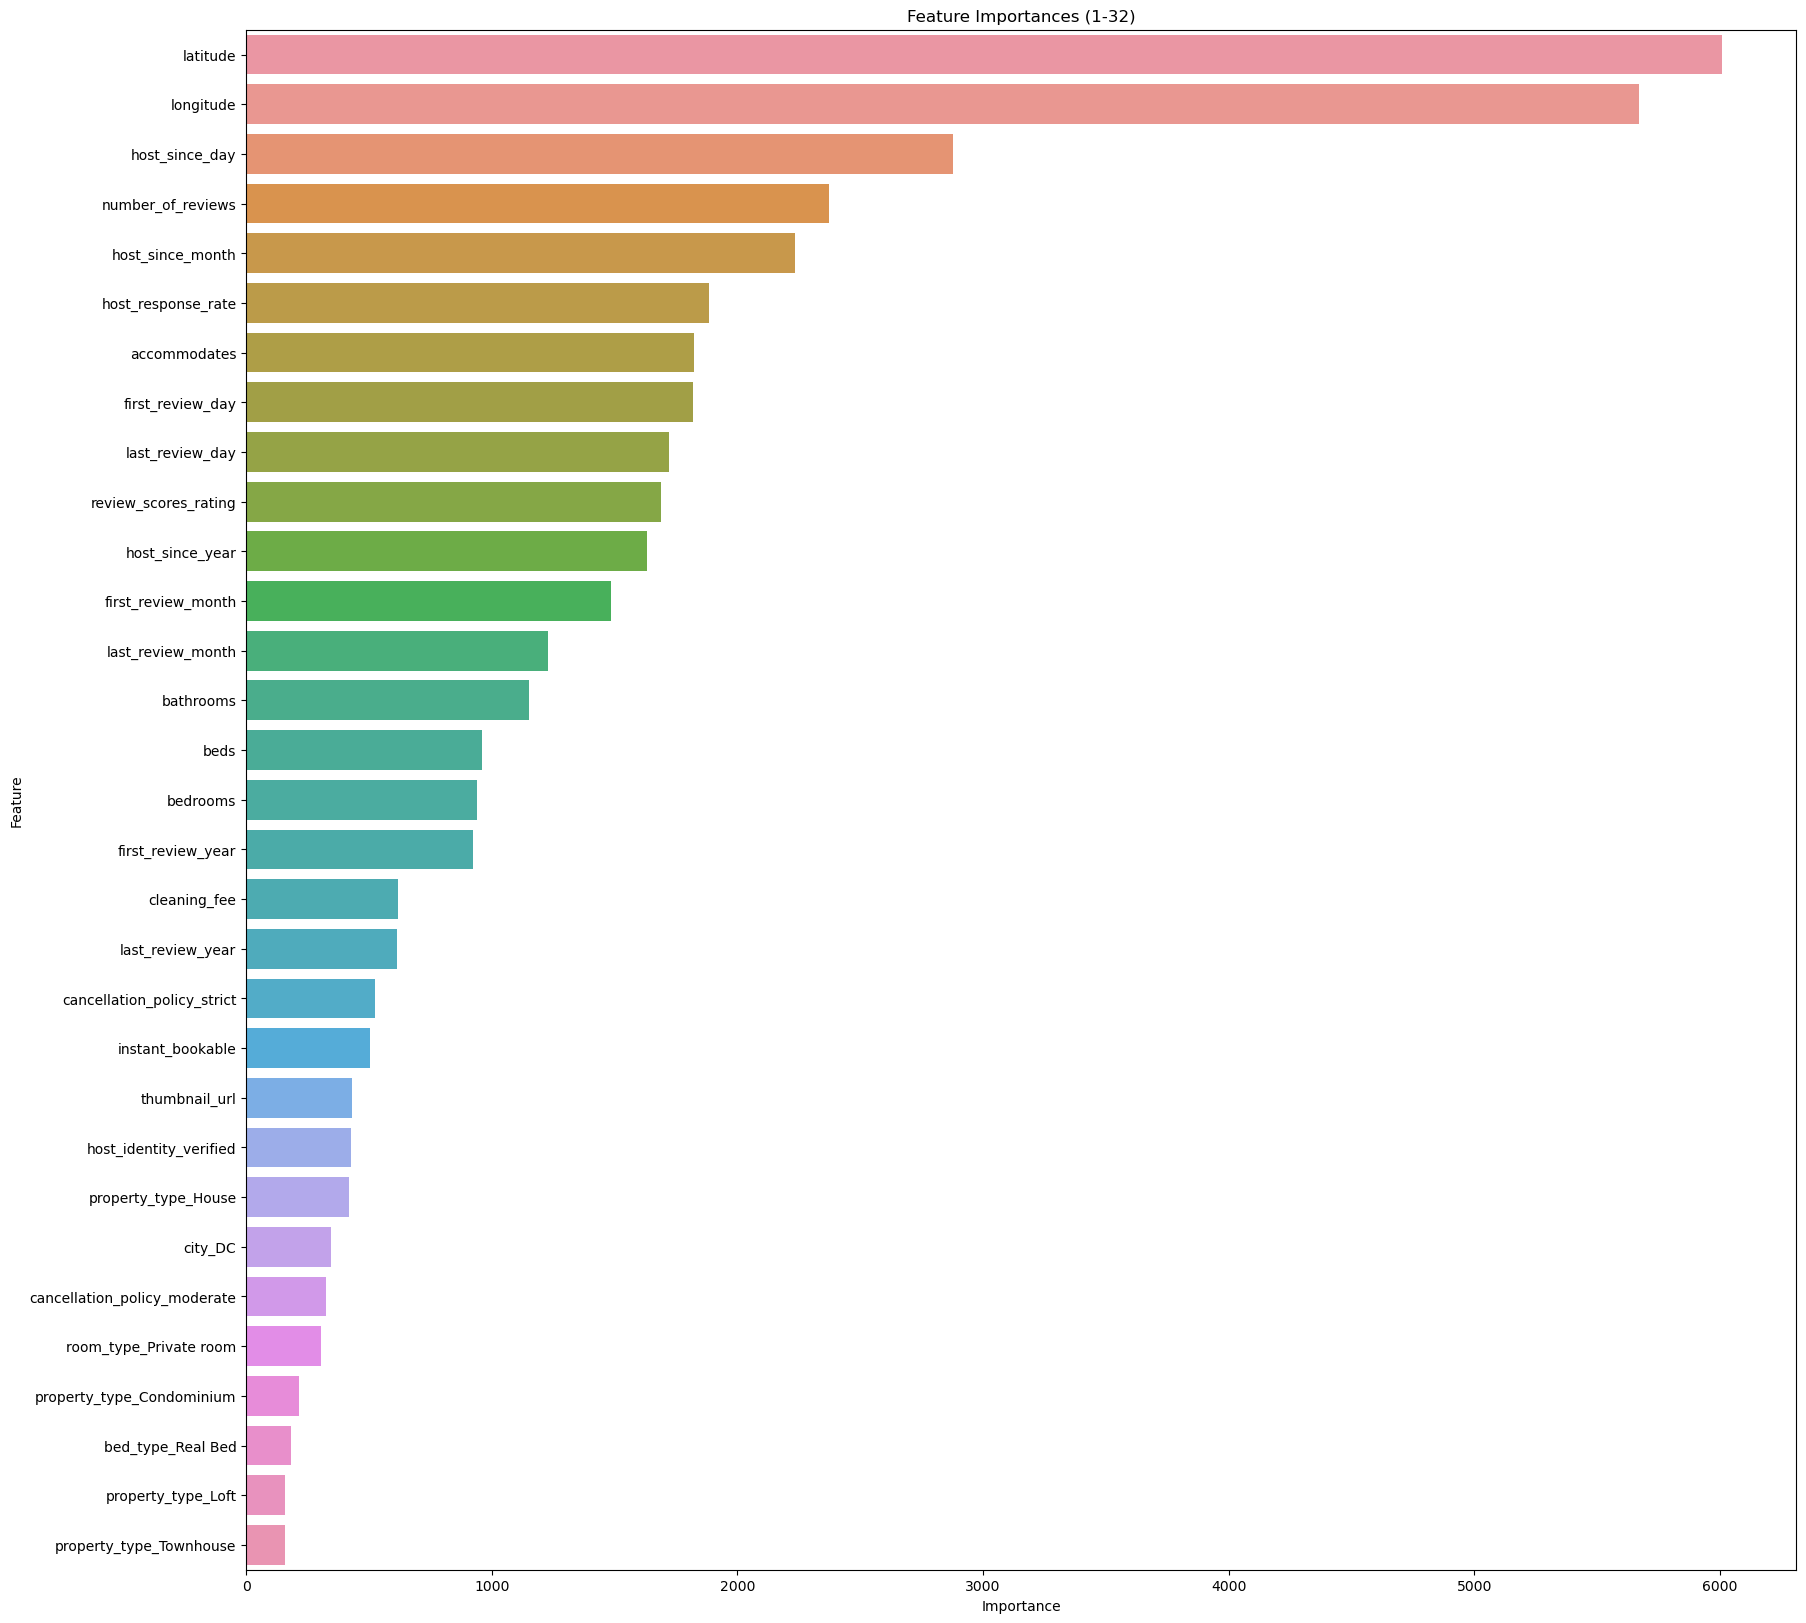

In [36]:
#plot feature importances

feat_importances = pd.DataFrame(boost.get_booster().get_fscore().items(), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(data=feat_importances.iloc[:len(feat_importances)//2], x='Importance', y='Feature', orient='h')
ax.set_title('Feature Importances (1-32)')

Text(0.5, 1.0, 'Feature Importances (33-64)')

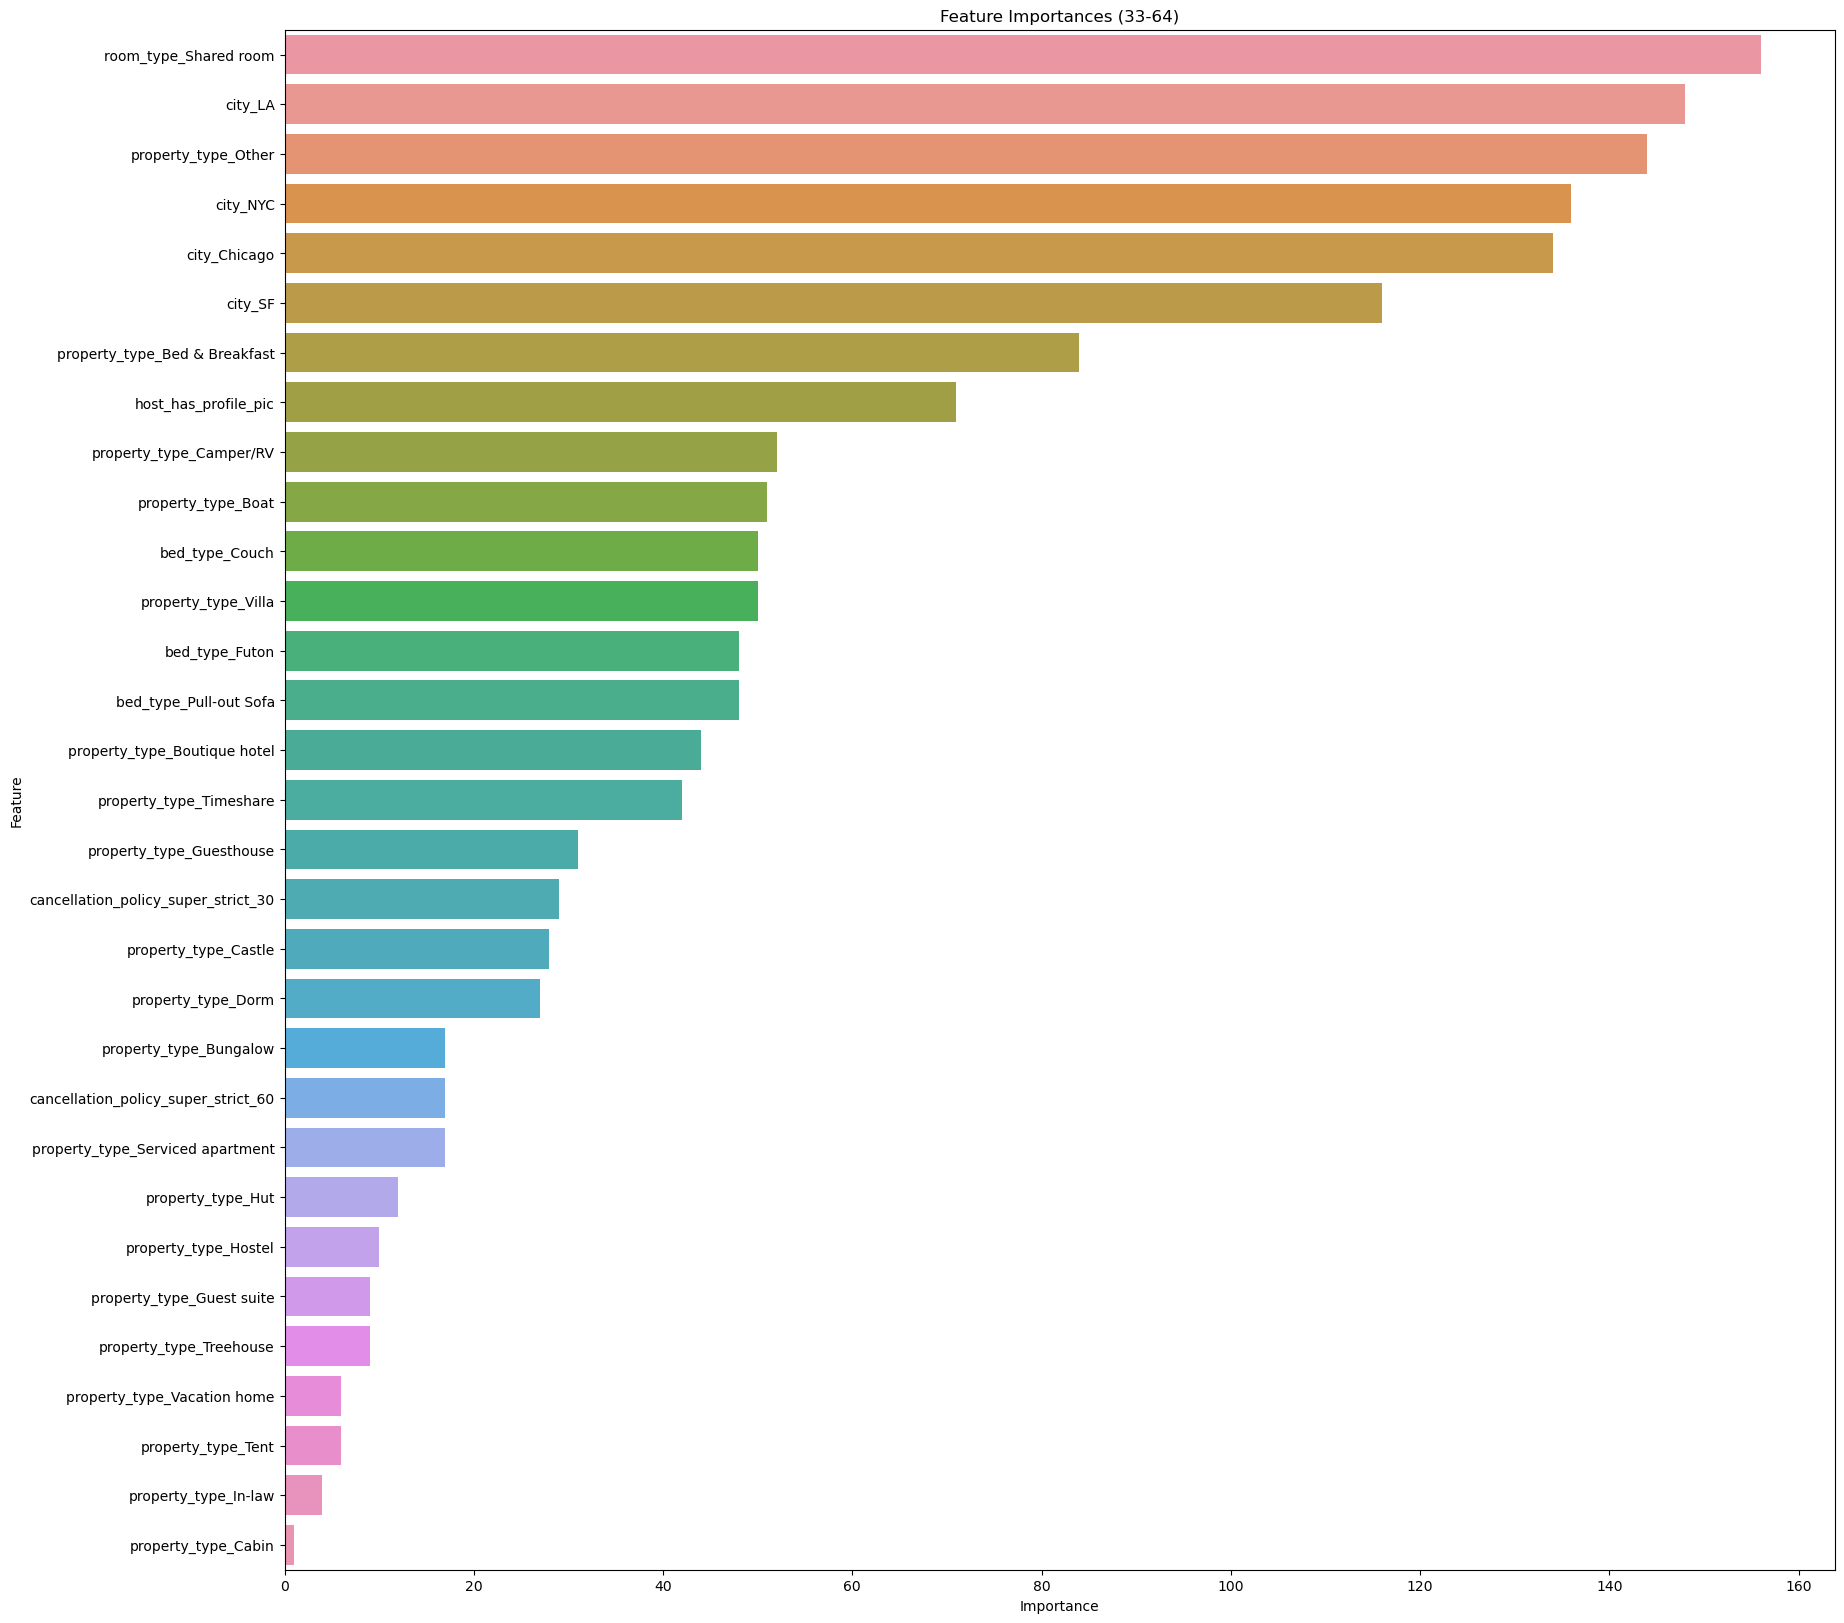

In [38]:
#feature importances (cont.)
#NOTE, THESE ARE SMALLER IN IMPORTANCE THAN ABOVE GRAPH DESPITE BAR SIZE

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(data=feat_importances.iloc[len(feat_importances)//2:], x='Importance', y='Feature', orient='h')
ax.set_title('Feature Importances (33-64)')